<a href="https://colab.research.google.com/github/BurgerBecker/optical_galaxy10_starter/blob/master/Galaxy10_example_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Run this initially to install the necessary dependencies
!pip install astroNN
!pip install --upgrade tensorflow

     |████████████████████████████████| 9.3MB 9.3MB/s 
     |████████████████████████████████| 4.4MB 66.4MB/s 
     |████████████████████████████████| 2.3MB 70.3MB/s 
  Created wheel for astroNN: filename=astroNN-1.0.1-cp36-none-any.whl size=9284595 sha256=208fe1568b31812bf93105817fd3605f00002e6b51d2156d4eee8244a2c48884
  Stored in directory: /root/.cache/pip/wheels/22/48/89/bcbab7475e4bff84e86a914145ea3ba907b6afb63f9fbe04b0
  Created wheel for astroquery: filename=astroquery-0.3.10-cp36-none-any.whl size=3508444 sha256=8934371392c3a51e567484b2250352d5241c480f7af090b049a6bc0db54cd830
  Stored in directory: /root/.cache/pip/wheels/cb/2f/df/06562d703b7f0577221c87174ae12bf4dcab0d40e8a02a8988
Successfully built astroNN astroquery
     |████████████████████████████████| 421.8MB 42kB/s 
     |████████████████████████████████| 3.8MB 42.2MB/s 
     |████████████████████████████████| 450kB 78.4MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
ERROR: tensorboard 2.1.0 has requirement 

In [0]:
import tensorflow as tf
# Checking that it's the latest version of TF
tf.__version__

'2.1.0'

#Introduction to CNN's
This notebook will serve as a quick introduction into classifying optical galaxy's using Convolutional Neural Networks (CNN's). For an in depth theoretical description, please read Ian Goodfellow's chapter on CNN's in the Deep Learning book: https://www.deeplearningbook.org/contents/convnets.html
##Dataset Description: Galaxy10
The dataset we're looking at is called Galaxy10 (https://astronn.readthedocs.io/en/latest/galaxy10.html). 

As described on the website:
"Galaxy10 is a dataset contains 25753 69x69 pixels colored galaxy images (g, r and i band) separated in 10 classes. Galaxy10 images come from Sloan Digital Sky Survey and labels come from Galaxy Zoo."

Galaxy Zoo is described in Lintott et al. 2008, MNRAS, 389, 1179 (https://ui.adsabs.harvard.edu/abs/2008MNRAS.389.1179L/abstract) and the data release is described in Lintott et al. 2011, 410, 166 (https://ui.adsabs.harvard.edu/abs/2011MNRAS.410..166L/abstract)

The initial setting up of the training data was taken from Henry Leung's github repo, the original of which can be found at:
https://github.com/henrysky/astroNN/blob/master/demo_tutorial/galaxy10/Galaxy10_Tutorial.ipynb

##Classes and Number of Sources

Galaxy10 dataset (25753 images):
+ Class 0 (3461 images): Disk, Face-on, No Spiral
+ Class 1 (6997 images): Smooth, Completely round
+ Class 2 (6292 images): Smooth, in-between round
+ Class 3 (394 images): Smooth, Cigar shaped
+ Class 4 (3060 images): Disk, Edge-on, Rounded Bulge
+ Class 5 (17 images): Disk, Edge-on, Boxy Bulge
+ Class 6 (1089 images): Disk, Edge-on, No Bulge
+ Class 7 (1932 images): Disk, Face-on, Tight Spiral
+ Class 8 (1466 images): Disk, Face-on, Medium Spiral
+ Class 9 (1045 images): Disk, Face-on, Loose Spiral

##Looking at the Stars

The code sample below will load the dataset, split it into a training and test set. It will also display some of the samples so you can get an idea what it looks like. 

My personal recommendation would be to read through the above articles and classify some galaxies on https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/ in order to get an intuitive feel for the data, but don't let this distract you from the task at hand: automating classification.

/root/.astroNN/datasets/Galaxy10.h5 was found!
===================Data Inspection===================


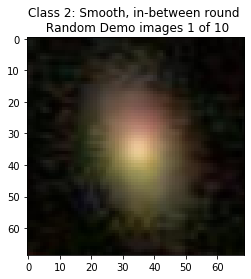

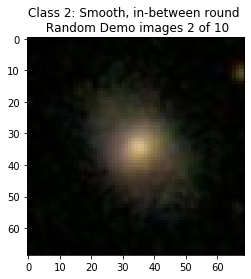

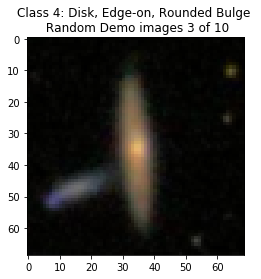

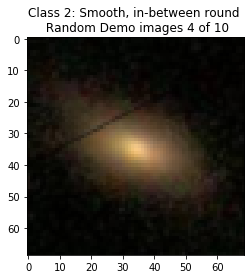

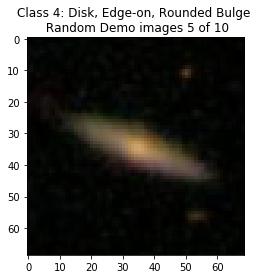

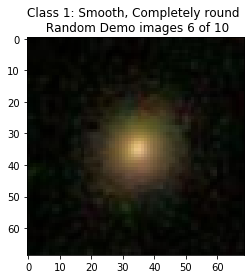

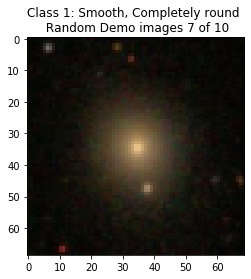

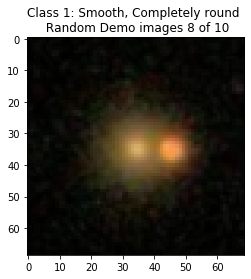

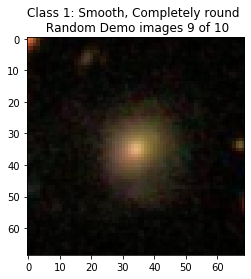

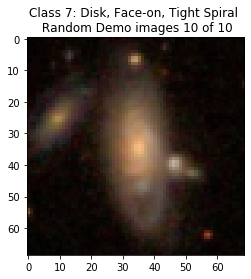

===============Data Inspection Finished===============


In [0]:
from tensorflow.keras import utils
from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup, galaxy10_confusion
import pylab as plt
import numpy as np
from sklearn.model_selection import train_test_split

# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/
images, labels = galaxy10.load_data()

# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# Select 10 of the images to inspect
img = None
plt.ion()
print('===================Data Inspection===================')
for counter, i in enumerate(range(np.random.randint(0, labels.shape[0], size=10).shape[0])):
    img = plt.imshow(images[i])
    plt.title('Class {}: {} \n Random Demo images {} of 10'.format(np.argmax(labels[i]), galaxy10cls_lookup(labels[i]), counter+1))
    plt.draw()
    plt.pause(2.)
plt.close('all')
print('===============Data Inspection Finished===============')

# To convert to desirable type
# labels = labels.astype(np.float32)
# images = images.astype(np.float32)

# Split the dataset into training set and testing set
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

#Data Preparation

Now we need to format our data in such a way that we can train our CNN on it.

This code has been adapted from the _Getting Started with Tensorflow 2_ guide (https://www.tensorflow.org/tutorials/quickstart/beginner). 

I'd advocate starting with Tensorflow 2 and Keras, but other great Deep Learning frameworks also exist with very detailed guides. 

(A personal favourite is Fast.ai (https://course.fast.ai/) with their Deep Learning for Coders course being an excellent guide: http://course18.fast.ai/ml )

Our dataset has been split into a training and a test set. It's important to note that these two sets should not overlap, we want to test whether the classifier has learned a characteristic of the class and isn't just good at classifying sources that it has seen already.

# Learning Rate

_"The learning rate is perhaps the most important hyperparameter. If you have time to tune only one hyperparameter, tune the learning rate."_ 

from Page 429 of _Deep Learning, 2016._

While I don't actively set the learning rate in the tutorial below, it is by far one of the most crucial elements to understand for anyone working with Deep Learning.

Below is a link to an excellent guide on learning rates, experiment and play around with this:

https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

In [0]:
# This was initially an MNIST example, now it's a Galaxy one. I'm too lazy to rename the variables


# Changing the encoding of your labels to class-indices instead of one-hot encodings
# train_labels=tf.argmax(train_labels,axis=1)
# test_labels=tf.argmax(test_labels,axis=1)

x_train, y_train, x_test, y_test = train_images, train_labels, test_images, test_labels
x_train, x_test = x_train / 255.0, x_test / 255.0


This is a simple feed forward neural network with 2 dense (or fully connected) layers. Each node in the first layer is connected with every node in the second layer. The second layer is our output layer, which needs to be the size of the number of classes that we have (10 in this case).

We feed in our image by flattening/reshaping it to a single column (69x69x3 = 14283) which is then fed into our first layer of size 256 (which seems like we're losing a lot of information in the process).

Run the cells below and see how the training goes.

In [0]:
model1 = None
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(69,69,3)),
  tf.keras.layers.Dense(256, activation='relu'),  
  tf.keras.layers.Dense(10, activation='softmax')
])

model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [0]:
model1.fit(x_train, y_train, epochs=10,shuffle=False)

model1.evaluate(x_test,  y_test, verbose=2)


Train on 19606 samples
Epoch 1/10
19606/19606 [==============================] - 3s 148us/sample - loss: 1.5410 - accuracy: 0.4165
Epoch 2/10
19606/19606 [==============================] - 3s 136us/sample - loss: 1.0902 - accuracy: 0.6116
Epoch 3/10
19606/19606 [==============================] - 3s 136us/sample - loss: 0.9697 - accuracy: 0.6544
Epoch 4/10
19606/19606 [==============================] - 3s 136us/sample - loss: 0.9050 - accuracy: 0.6786
Epoch 5/10
19606/19606 [==============================] - 3s 139us/sample - loss: 0.8590 - accuracy: 0.6955
Epoch 6/10
19606/19606 [==============================] - 3s 138us/sample - loss: 0.8231 - accuracy: 0.7063
Epoch 7/10
19606/19606 [==============================] - 3s 135us/sample - loss: 0.7917 - accuracy: 0.7192
Epoch 8/10
19606/19606 [==============================] - 3s 136us/sample - loss: 0.7636 - accuracy: 0.7279
Epoch 9/10
19606/19606 [==============================] - 3s 138us/sample - loss: 0.7410 - accuracy: 0.7373
Epoch

[1.0413157483917577, 0.6672786]

Not too bad for such a simple setup, but we can do better if we don't lose that much information before we even start training. We could use a larger dense/fully connected layer? But then we lose the relative spatial information given by the 2D image.

This is where the 2D convolutional layer comes in, it keeps the 2D layout of the image by looking at small parts of the image at a time (called the kernel size, which is 3x3 in this example), then applying an opperation to it and storing this as a single value.

What does it do at the edges? Well, you can tell it what to do, but by default it's padding some values there.

In [0]:
model2 = None
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32,kernel_size=(3,3),input_shape=(69,69,3),activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),  
  tf.keras.layers.Dense(10, activation='softmax')
])

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [0]:
model2.fit(x_train, y_train, epochs=10,shuffle=False)

model2.evaluate(x_test,  y_test, verbose=2)


Train on 19606 samples
Epoch 1/10
19606/19606 [==============================] - 10s 500us/sample - loss: 1.3639 - accuracy: 0.4907
Epoch 2/10
19606/19606 [==============================] - 9s 485us/sample - loss: 0.8835 - accuracy: 0.6842
Epoch 3/10
19606/19606 [==============================] - 10s 486us/sample - loss: 0.7094 - accuracy: 0.7500
Epoch 4/10
19606/19606 [==============================] - 9s 478us/sample - loss: 0.5362 - accuracy: 0.8201
Epoch 5/10
19606/19606 [==============================] - 9s 474us/sample - loss: 0.3845 - accuracy: 0.8770
Epoch 6/10
19606/19606 [==============================] - 9s 476us/sample - loss: 0.2752 - accuracy: 0.9102
Epoch 7/10
19606/19606 [==============================] - 9s 474us/sample - loss: 0.1990 - accuracy: 0.9376
Epoch 8/10
19606/19606 [==============================] - 9s 481us/sample - loss: 0.1667 - accuracy: 0.9447
Epoch 9/10
19606/19606 [==============================] - 9s 475us/sample - loss: 0.1265 - accuracy: 0.9583
Epo

[1.5893402073896494, 0.70032126]

Not a massive increase in accuracy (if at all, since these runs are non-deterministic and you might be getting completely different values). This model does perform much better on our training data, going up to 95% accuracy. 

Why then does it do nearly the same as our other model in training? We might be overfitting, but we can't say this until we've made a validation set to test this (https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7). You can try this later.

We're still stuck with a massive vector being flattened and then pushed into a much smaller value and losing information.

This is where max Pooling comes in. It pools values over a certain local region (3x3) and stores this value. This shrinks the overall size of the data while (hopefully) keeping the more crucial bits of information.

In [0]:
model3 = None
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32,kernel_size=(3,3),input_shape=(69,69,3),activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),  
  tf.keras.layers.Dense(10, activation='softmax')
])

model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [0]:
model3.fit(x_train, y_train, epochs=10,shuffle=False)

model3.evaluate(x_test,  y_test, verbose=2)


Train on 19606 samples
Epoch 1/10
19606/19606 [==============================] - 5s 279us/sample - loss: 1.2892 - accuracy: 0.4862
Epoch 2/10
19606/19606 [==============================] - 5s 263us/sample - loss: 0.9572 - accuracy: 0.6476
Epoch 3/10
19606/19606 [==============================] - 5s 269us/sample - loss: 0.7994 - accuracy: 0.7134
Epoch 4/10
19606/19606 [==============================] - 5s 265us/sample - loss: 0.6712 - accuracy: 0.7651
Epoch 5/10
19606/19606 [==============================] - 5s 267us/sample - loss: 0.5482 - accuracy: 0.8125
Epoch 6/10
19606/19606 [==============================] - 5s 268us/sample - loss: 0.4384 - accuracy: 0.8566
Epoch 7/10
19606/19606 [==============================] - 5s 268us/sample - loss: 0.3487 - accuracy: 0.8855
Epoch 8/10
19606/19606 [==============================] - 5s 264us/sample - loss: 0.2804 - accuracy: 0.9105
Epoch 9/10
19606/19606 [==============================] - 5s 264us/sample - loss: 0.2443 - accuracy: 0.9209
Epoch

[1.2725145569453276, 0.6920606]

Adding depth (more filters) to the network while you decrease the output tensor's size is where Deep Learning gets its name from. Our second convolutional layer has twice the number of filters.

In [0]:
model4 = None
model4 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16,kernel_size=(3,3),input_shape=(69,69,3),activation='relu'),  
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),  
  tf.keras.layers.Dense(10, activation='softmax')
])

model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [0]:
model4.fit(x_train, y_train, epochs=10,shuffle=False)

model4.evaluate(x_test,  y_test, verbose=2)


Train on 19606 samples
Epoch 1/10
19606/19606 [==============================] - 5s 241us/sample - loss: 1.2624 - accuracy: 0.4950
Epoch 2/10
19606/19606 [==============================] - 4s 220us/sample - loss: 0.8658 - accuracy: 0.6815
Epoch 3/10
19606/19606 [==============================] - 4s 217us/sample - loss: 0.7183 - accuracy: 0.7392
Epoch 4/10
19606/19606 [==============================] - 4s 218us/sample - loss: 0.6210 - accuracy: 0.7747
Epoch 5/10
19606/19606 [==============================] - 4s 218us/sample - loss: 0.5480 - accuracy: 0.8050
Epoch 6/10
19606/19606 [==============================] - 4s 219us/sample - loss: 0.4794 - accuracy: 0.8300
Epoch 7/10
19606/19606 [==============================] - 4s 224us/sample - loss: 0.4164 - accuracy: 0.8509
Epoch 8/10
19606/19606 [==============================] - 4s 222us/sample - loss: 0.3591 - accuracy: 0.8753
Epoch 9/10
19606/19606 [==============================] - 4s 219us/sample - loss: 0.3103 - accuracy: 0.8930
Epoch

[0.9656755252407472, 0.73841214]

Larger kernel sizes and an additional Conv layer:

In [0]:
model4 = None
model4 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16,kernel_size=(11,11),input_shape=(69,69,3),activation='relu'),  
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(32,kernel_size=(7,7),activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
  tf.keras.layers.MaxPool2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),  
  tf.keras.layers.Dense(10, activation='softmax')
])

model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [0]:
model4.fit(x_train, y_train, epochs=10,shuffle=False)

model4.evaluate(x_test,  y_test, verbose=2)


Train on 19606 samples
Epoch 1/10
19606/19606 [==============================] - 7s 347us/sample - loss: 1.2762 - accuracy: 0.5048
Epoch 2/10
19606/19606 [==============================] - 6s 319us/sample - loss: 0.8976 - accuracy: 0.6677
Epoch 3/10
19606/19606 [==============================] - 6s 321us/sample - loss: 0.7831 - accuracy: 0.7119
Epoch 4/10
19606/19606 [==============================] - 6s 316us/sample - loss: 0.7091 - accuracy: 0.7406
Epoch 5/10
19606/19606 [==============================] - 6s 316us/sample - loss: 0.6601 - accuracy: 0.7562
Epoch 6/10
19606/19606 [==============================] - 6s 319us/sample - loss: 0.6235 - accuracy: 0.7705
Epoch 7/10
19606/19606 [==============================] - 6s 320us/sample - loss: 0.5856 - accuracy: 0.7820
Epoch 8/10
19606/19606 [==============================] - 6s 319us/sample - loss: 0.5586 - accuracy: 0.7949
Epoch 9/10
19606/19606 [==============================] - 6s 319us/sample - loss: 0.5360 - accuracy: 0.8037
Epoch

[0.6663954466677084, 0.7810922]